In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
from IPython.display import clear_output
from itertools import product, combinations
import json

In [509]:
league_id = 78 # Choose the league id

season_file = '2015-2022'

first_season = 2015
last_season = 2021

features = ['HOME_PTS_PCT', 'HOME_WIN_PCT', 'HOME_DRAW_PCT', 'HOME_LOSS_PCT', 'HOME_HOME_WIN_PCT', 'HOME_HOME_DRAW_PCT', 'HOME_HOME_LOSS_PCT', f'HOME_WIN_PCT_LAST_GAMES', f'HOME_DRAW_PCT_LAST_GAMES', f'HOME_LOSS_PCT_LAST_GAMES','HOME_SCORE_LAST_GAMES', 'HOME_CONCEDED_LAST_GAMES', 'HOME_SHOTS_ON_GOAL_LAST_GAMES', 'HOME_SHOTS_OFF_GOAL_LAST_GAMES', 'HOME_TOTAL_SHOTS_LAST_GAMES', 'HOME_BLOCKED_SHOTS_LAST_GAMES','HOME_SHOTS_INSIDE_BOX_LAST_GAMES', 'HOME_SHOTS_OUTSIDE_BOX_LAST_GAMES', 'HOME_FOULS_LAST_GAMES', 'HOME_CORNERS_LAST_GAMES', 'HOME_OFFSIDES_LAST_GAMES','HOME_POSSESSION_LAST_GAMES', 'HOME_YELLOW_CARDS_LAST_GAMES', 'HOME_RED_CARDS_LAST_GAMES', 'HOME_SAVES_LAST_GAMES', 'HOME_TOTAL_PASSES_LAST_GAMES','HOME_PASSES_ACCURATE_LAST_GAMES', 'HOME_PASSES_PCT_LAST_GAMES',
           'AWAY_PTS_PCT', 'AWAY_WIN_PCT', 'AWAY_DRAW_PCT', 'AWAY_LOSS_PCT', 'AWAY_AWAY_WIN_PCT', 'AWAY_AWAY_DRAW_PCT', 'AWAY_AWAY_LOSS_PCT', f'AWAY_WIN_PCT_LAST_GAMES', f'AWAY_DRAW_PCT_LAST_GAMES', f'AWAY_LOSS_PCT_LAST_GAMES','AWAY_SCORE_LAST_GAMES', 'AWAY_CONCEDED_LAST_GAMES', 'AWAY_SHOTS_ON_GOAL_LAST_GAMES', 'AWAY_SHOTS_OFF_GOAL_LAST_GAMES', 'AWAY_TOTAL_SHOTS_LAST_GAMES', 'AWAY_BLOCKED_SHOTS_LAST_GAMES','AWAY_SHOTS_INSIDE_BOX_LAST_GAMES', 'AWAY_SHOTS_OUTSIDE_BOX_LAST_GAMES', 'AWAY_FOULS_LAST_GAMES', 'AWAY_CORNERS_LAST_GAMES', 'AWAY_OFFSIDES_LAST_GAMES','AWAY_POSSESSION_LAST_GAMES', 'AWAY_YELLOW_CARDS_LAST_GAMES', 'AWAY_RED_CARDS_LAST_GAMES', 'AWAY_SAVES_LAST_GAMES', 'AWAY_TOTAL_PASSES_LAST_GAMES','AWAY_PASSES_ACCURATE_LAST_GAMES', 'AWAY_PASSES_PCT_LAST_GAMES']
targets = ['OUTCOME']

min_threshold = 1.75
max_threshold = 10

totals_max_threshold = 55
totals_min_threshold = 45

default_odds_value = 1.9

first_attr_index = 9

# default_stake = 50
bankroll = 2000
stake = 0.025

In [510]:
print('\nGetting data for the model...')

season = "{}-{}".format(first_season, last_season)

default_path = f'./leagues/{league_id}'
whole_dataset = pd.read_csv(f"{default_path}/data/{season_file}.csv")
whole_dataset = whole_dataset.loc[(whole_dataset['HOME_ODDS'].notna()) & (whole_dataset['AWAY_ODDS'].notna())]
whole_dataset['GAME_DATE'] = pd.to_datetime(whole_dataset['GAME_DATE']).dt.date


Getting data for the model...


In [511]:
whole_dataset.head()

,Unnamed: 0,GAME_ID,GAME_DATE,SEASON,HOME_TEAM,AWAY_TEAM,HOME_ODDS,AWAY_ODDS,DRAW_ODDS,HOME_PTS_PCT,...,AWAY_POSSESSION_LAST_GAMES,AWAY_YELLOW_CARDS_LAST_GAMES,AWAY_RED_CARDS_LAST_GAMES,AWAY_SAVES_LAST_GAMES,AWAY_TOTAL_PASSES_LAST_GAMES,AWAY_PASSES_ACCURATE_LAST_GAMES,AWAY_PASSES_PCT_LAST_GAMES,OUTCOME,HOME_SCORE,AWAY_SCORE
0,0,194658,2015-10-31,2015,Schalke,Ingolstadt,1.77,4.94,3.66,63.333333,...,46.4,1.8,0.0,1.8,386.4,266.0,68.4,D,1,1
1,1,194660,2015-10-31,2015,Werder Bremen,Dortmund,7.80,1.38,5.30,33.333333,...,59.0,0.6,0.0,3.2,582.2,480.0,81.6,A,1,3
2,2,194661,2015-10-31,2015,FC Koln,Hoffenheim,2.17,3.45,3.40,46.666667,...,40.4,2.6,0.2,5.0,342.0,239.4,69.0,D,0,0
3,3,194666,2015-11-06,2015,Hannover,Hertha Berlin,2.70,2.77,3.20,33.333333,...,46.6,2.2,0.2,3.2,456.4,358.2,78.4,A,1,3
4,4,194667,2015-11-07,2015,Bayern Munich,Stuttgart,1.11,23.90,11.09,93.939394,...,50.2,3.4,0.2,3.6,381.8,260.0,67.0,H,4,0


In [512]:
def plot_chart(title, x_label, y_label):
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    
    path = 'charts'
    if not os.path.exists(path):
        os.makedirs(path)
    
    plt.savefig(f"{path}/{title.replace(' ','_').lower()}.png", dpi=300)
    plt.show()

def plot_hist(title, x_label, y_label, data):
    plt.hist(data, density=False, bins=20)  # density=False would make counts
    plot_chart(title, x_label, y_label)
    
def plot_bar(title, x_label, y_label, x_data, y_data):
    ax= plt.subplot()
    plt.bar(x_data, y_data) 
    # plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.xticks(fontsize=10, rotation=90)
    plot_chart(title, x_label, y_label)
    
def plot_pie_chart(title, labels, data):
    try:
        data_converted = np.unique(data, return_counts=True)[1]
        plt.pie(data_converted, labels = labels, startangle = 90, shadow = True, autopct='%.2f%%')
        plt.title(title)
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show() 
    except Exception as e:
        print(f'Error when trying to plot the pie chart: {e}')

def check_bet_worth(prediction, odds_home, odds_away, odds_draw):
    return ((prediction == 'H' and (odds_home > min_threshold and odds_home < max_threshold)) or 
            (prediction == 'A' and (odds_away > min_threshold and odds_away < max_threshold)) or 
            (prediction == 'D' and (odds_draw > min_threshold and odds_draw < max_threshold)))

def check_model_performance_on_game(game, prediction, bet_value):
    game_money = 0
            
#     goal_diff_pred = abs(home_pred_score - away_pred_score)
#     if goal_diff_pred > 0.2 and goal_diff_pred < 0.4:
#         return game_money
    
    if check_bet_worth(prediction, game['HOME_ODDS'], game['AWAY_ODDS'], game['DRAW_ODDS']):
        if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
            game_money = (bet_value*game['HOME_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
            game_money = (bet_value*game['AWAY_ODDS'] - bet_value)
        elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
            game_money = (bet_value*game['DRAW_ODDS'] - bet_value)
        else:
            game_money = -bet_value
            
    return game_money

def get_bet_value(bankroll):
    bankroll_baseline = round(bankroll / 1000, 0) * 1000
    return stake * bankroll_baseline
#     return default_stake

In [513]:
def get_feature_correlation_matrix(dataset):
    print('\nGetting the feature correlation matrix...')

    import seaborn as sns

    try:
        dependent_variables = dataset.iloc[:,first_attr_index:]
        corrmat = dependent_variables.corr()
        top_corr_features = corrmat.index
        plt.figure(figsize=(13,13))
        title = 'Feature Correlation'
        plt.title(title)
        #plot heat map
        sns.set(font_scale=0.6)
        g=sns.heatmap(dependent_variables.corr(),annot=True,cmap='Blues', fmt='0.1g')
        plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
        plt.show()
    except:
        print('No correlation matrix for the selected model.')

In [514]:
def simulate_by_model(predictions, dataset_itr):
    money_by_date = []
    bets = []
    money_by_team = dict()
    total_invested = 0
    outcome_predictions = {'H': 0, 'A': 0, 'D': 0}
    strikes = 0
    no_value_games = []

    money_by_date.append({
        'date': dataset_itr.iloc[0,2],
        'date_profit': 0,
        'total_bankroll': bankroll
    })

    for index, game in dataset_itr.iterrows():
        bet_value = get_bet_value(money_by_date[-1]['total_bankroll'])
        
        # Next date
        if game['GAME_DATE'] != money_by_date[-1]['date']:
                
            money_by_date.append({
                'date': game['GAME_DATE'],
                'date_profit': 0,
                'total_bankroll': money_by_date[-1]['total_bankroll']
            })

        if game['HOME_TEAM'] not in money_by_team:
            money_by_team[game['HOME_TEAM']] = 0
        if game['AWAY_TEAM'] not in money_by_team:
            money_by_team[game['AWAY_TEAM']] = 0

#         home_score_pred, away_score_pred = predictions[index]
        
#         prediction = 'D'
#         score_pred_diff = abs(home_score_pred - away_score_pred)
#         if home_score_pred > away_score_pred and score_pred_diff > 0.2:
#             prediction = 'H'
#         elif home_score_pred < away_score_pred and score_pred_diff > 0.2:
#             prediction = 'A'

        prediction = predictions[index]
        
        if prediction == game['OUTCOME']:
            strikes += 1

        game_money_model = 0

#         game_money_model = check_model_performance_on_game(game, prediction, bet_value, home_score_pred, away_score_pred)
        game_money_model = check_model_performance_on_game(game, prediction, bet_value)

        if game_money_model != 0:       
            if game['OUTCOME'] == prediction and game['OUTCOME'] == 'H':
                bets.append(['HOME', game['HOME_ODDS'], 1])
                money_by_team[game['HOME_TEAM']] += game_money_model
            elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'A':
                bets.append(['AWAY', game['AWAY_ODDS'], 1])
                money_by_team[game['AWAY_TEAM']] += game_money_model
            elif game['OUTCOME'] == prediction and game['OUTCOME'] == 'D':
                bets.append(['DRAW', game['DRAW_ODDS'], 1])
            else:
                if prediction == 'H':
                    bets.append(['HOME', game['HOME_ODDS'], 0])
                    money_by_team[game['HOME_TEAM']] += game_money_model
                elif prediction == 'A':
                    bets.append(['AWAY', game['AWAY_ODDS'], 0])
                    money_by_team[game['AWAY_TEAM']] += game_money_model
                elif prediction == 'D':
                    bets.append(['DRAW', game['DRAW_ODDS'], 0])

            total_invested += bet_value

        outcome_predictions[prediction] += 1

        money_by_date[-1]['date_profit'] += game_money_model
        money_by_date[-1]['total_bankroll'] += game_money_model
        
    return {
        'results': money_by_date,
        'outcome_distribution': outcome_predictions,
        'bets': bets,
        'profit_by_team': money_by_team,
        'total_invested': total_invested,
        'strike_rate': strikes * 100 / len(dataset_itr.index),
    }


In [515]:
def save_league_season_results(result, season_train, season_test):
    path = f"leagues/{league_id}/results/regression"
    file_name = f"{season_train}-{season_test}.json"

    if not os.path.exists(path):
        os.makedirs(path)

    with open(f"{path}/{file_name}", 'w') as f:
        json.dump(result['results'], f, indent = 4, sort_keys = True, default = str)

In [516]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

def train_model(dataset):
    X = dataset.loc[:, features]
    y = dataset[targets]
    
#     " Random Search CV Optmizer "
#     classifier = RandomForestClassifier()
    
#     # Number of trees in random forest
#     n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
#     # Number of features to consider at every split
#     max_features = ['sqrt', 'log2', None]
#     # Maximum number of levels in tree
#     max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#     max_depth.append(None)
#     # Minimum number of samples required to split a node
#     min_samples_split = [2, 5, 10]
#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = [1, 2, 4]
#     # Method of selecting samples for training each tree
#     bootstrap = [True, False]
#     # Create the random grid
#     random_grid = {'n_estimators': n_estimators,
#                     'max_features': max_features,
#                     'max_depth': max_depth,
#                     'min_samples_split': min_samples_split,
#                     'min_samples_leaf': min_samples_leaf,
#                     'bootstrap': bootstrap}
                   
#     rf_random = RandomizedSearchCV(estimator = classifier, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
#     rf_random.fit(X, y)
    
#     best_random = rf_random.best_estimator_
#     best_parameters = rf_random.cv_results_
#     print(best_parameters)
#     print(best_random)
    
#     return rf_random
    
#     model = RandomForestRegressor(max_depth=10, max_features='log2', min_samples_split=10,
#                       n_estimators=2000, random_state=0)
    model = RandomForestClassifier(max_depth=60, max_features='log2', min_samples_leaf=4,
                       n_estimators=2000)
    
    model.fit(X.values, y.values)
    
    return model

In [517]:
# dataset_test = whole_dataset.loc[(whole_dataset['SEASON'] >= first_season) & (whole_dataset['SEASON'] < 2022)].reset_index(drop=True)
# train_regression_model(dataset_test)

In [518]:
def predict(dataset_train, dataset_itr):
    
    model = train_model(dataset_train)

    X = dataset_itr.loc[:, features]
    
    if not len(X):
        return None, model
    
    predictions = model.predict(X.values)
    
    return predictions, model

In [519]:
def simulate(season):
    print(f"\Simultating the results for season {season}...")
    
    dataset_train = whole_dataset.loc[(whole_dataset['SEASON'] >= first_season) & (whole_dataset['SEASON'] < season)].reset_index(drop=True)
    dataset_itr = whole_dataset.loc[whole_dataset['SEASON'] == season].reset_index(drop=True)
    
    clear_output(wait=True)

    print(f"Season {season}/{last_season}")

    predictions, model = predict(dataset_train, dataset_itr)

    result = dict()
    
    if predictions is None:
        pass
    else:
        result = simulate_by_model(predictions, dataset_itr)
        save_league_season_results(result, first_season, season)
        
    result['seasons'] = f"{first_season}-{season}"
    result['model'] = model
        
    return result


In [520]:
results = []

for season in range(first_season + 1, last_season + 1):
    results.append(simulate(season))

Season 2021/2021


C:\Users\caiog\AppData\Local\Temp\ipykernel_16812\3728125700.py:50: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X.values, y.values)


In [521]:
results.sort(key=lambda x: x['results'][-1]['total_bankroll'], reverse=True)

In [522]:
def print_bankroll_update(result):
    won = result['results'][-1]['total_bankroll'] - bankroll
    print(f"\nSeasons: {result['seasons']} // Accuracy: {round(result['strike_rate'], 2)}%")
    print(f"Total moneyline bets: {len([r for r in result['bets'] if r[2]])}")
    print(f"Yield: {round(won*100/result['total_invested'], 2)}% // Bet Accuracy: {round(len([r for r in result['bets'] if r[2]])*100/len(result['bets']), 2)}% \nBankroll: {round(result['results'][-1]['total_bankroll'], 2)} // Won: {round(won, 2)} // Margin: {round(100*won/bankroll, 2)}%")

In [523]:
for r in results:
    print_bankroll_update(r)


Seasons: 2015-2017 // Accuracy: 48.8%
Total moneyline bets: 61
Yield: 1.27% // Bet Accuracy: 41.5% 
Bankroll: 2094.5 // Won: 94.5 // Margin: 4.72%

Seasons: 2015-2021 // Accuracy: 50.48%
Total moneyline bets: 51
Yield: -2.29% // Bet Accuracy: 39.53% 
Bankroll: 1851.5 // Won: -148.5 // Margin: -7.42%

Seasons: 2015-2019 // Accuracy: 50.71%
Total moneyline bets: 48
Yield: -5.87% // Bet Accuracy: 39.02% 
Bankroll: 1646.25 // Won: -353.75 // Margin: -17.69%

Seasons: 2015-2016 // Accuracy: 46.26%
Total moneyline bets: 58
Yield: -13.39% // Bet Accuracy: 39.19% 
Bankroll: 1307.25 // Won: -692.75 // Margin: -34.64%

Seasons: 2015-2020 // Accuracy: 49.53%
Total moneyline bets: 47
Yield: -18.51% // Bet Accuracy: 36.72% 
Bankroll: 1231.75 // Won: -768.25 // Margin: -38.41%

Seasons: 2015-2018 // Accuracy: 49.3%
Total moneyline bets: 39
Yield: -21.46% // Bet Accuracy: 32.5% 
Bankroll: 1141.75 // Won: -858.25 // Margin: -42.91%


In [524]:
result_for_analysis = results[-1]

In [525]:
print(result_for_analysis['outcome_distribution'])

{'H': 164, 'A': 35, 'D': 14}


In [526]:
print('\nPlotting charts...')

models_tracking =  [np.array([x['total_bankroll'] for x in result_for_analysis['results']], dtype=np.float32)]

money_by_date = np.array([[r['date'], r['total_bankroll']] for r in result_for_analysis['results']], dtype=str)
correct_bets = list(filter(lambda x: x[2] == 1, result_for_analysis['bets']))
missed_bets = list(filter(lambda x: x[2] == 0, result_for_analysis['bets']))
correct_bets_odds = np.array(list(map(lambda x: x[1], correct_bets)))
missed_bets_odds = np.array(list(map(lambda x: x[1], missed_bets)))
correct_bets_home = np.array(list(map(lambda x: x[0], correct_bets)))
missed_bets_home = np.array(list(map(lambda x: x[0], missed_bets)))

money_by_team = dict(sorted(result_for_analysis['profit_by_team'].items(), key=lambda x: x[1]))
money_by_team_labels = np.array(list(money_by_team.keys()), dtype=str)
money_by_team_values = np.array(list(money_by_team.values()), dtype=np.float32)


Plotting charts...


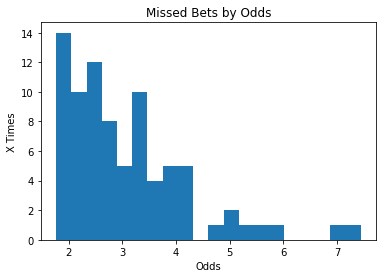

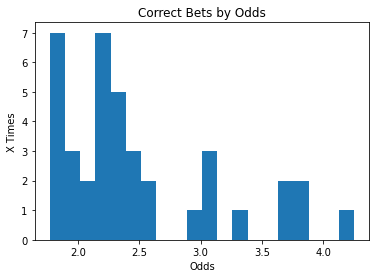

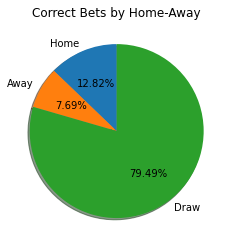

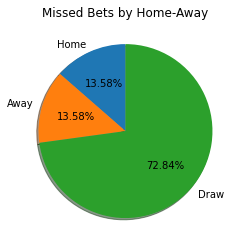

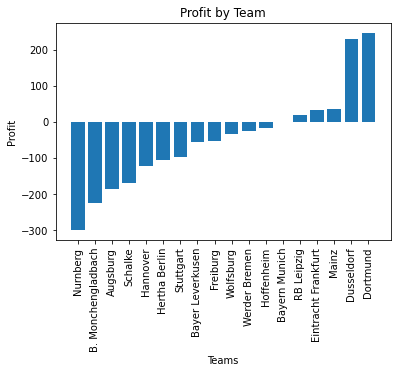

In [527]:
plot_hist('Missed Bets by Odds', 'Odds', 'X Times', missed_bets_odds)

plot_hist('Correct Bets by Odds', 'Odds', 'X Times', correct_bets_odds)

plot_pie_chart('Correct Bets by Home-Away', ['Home', 'Away', 'Draw'], correct_bets_home)

plot_pie_chart('Missed Bets by Home-Away', ['Home', 'Away', 'Draw'], missed_bets_home)

plot_bar('Profit by Team', 'Teams', 'Profit', money_by_team_labels, money_by_team_values)

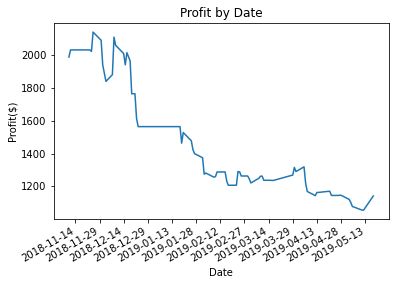

In [528]:
xpoints = money_by_date[:, 0].astype(np.datetime64)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
for model in models_tracking:
    plt.plot(xpoints, model)

title = "Profit by Date"
plt.ylabel("Profit($)")
plt.xlabel("Date")
plt.title(title)
plt.gcf().autofmt_xdate()
plt.savefig('charts/{}.png'.format(title.replace(' ','_').lower()), dpi=300)
plt.show()

In [529]:
from joblib import dump, load

save_current_season_model = False
current_season = 2022

if save_current_season_model:
    result = simulate(current_season)
    dump(result['model'], f'{league_id}/model.joblib')